In [12]:
%matplotlib notebook
import numpy as np
from uncertainties import ufloat
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("/home/pablo/CinePy")
from constantes.lectura import lee_constantes_retardados
from constantes.constantes_reactores import RA3 as REACTOR
from modules.point_kinetics.reactimeter import reactimetro
from modules.point_kinetics.direct_kinetic_solver import cinetica_directa
from modules.point_kinetics.ajuste_CEM import lee_archivo_CIN, deteccion_borde, \
                                deteccion_tiempo_caida, salto_instantaneo_espacial, \
                                ajuste_simulacion_espacial, estima_reactividad_reactimetro

# Algoritmo para estimar reactividades con un rod-drop

El ajuste se realiza con la función $f(t)$ en la evolución retardada. No tiene sentido definirla para todo tiempo (**¿no es contínua?**)

\begin{align}
f(t) &= A_1 \sum_{i=1}^7 B_i e^{\omega_i (t-t_0-t_b)} + A_3
\end{align}


donde los coeficientes $B_i$ se definen como:

\begin{equation}
B_i = \frac{\$_0 / \omega_i}{\Lambda^*  + \sum_{j=1}^6 \frac{b_j\lambda_j}{(\omega_i + \lambda_j)^2}}
\end{equation}

y los $\omega_i$ son las soluciones de la ecuación in-hour:

\begin{equation}
\$_0 = \Lambda^* \omega + \omega \sum_{i=1}^6 \frac{b_i}{\omega + \lambda_i}
\end{equation}

Definición de los tiempos:

 * $t_0$ : tiempo en donde comienza la caída de barras (o el cambio en reactividad). Se obtiene de la medición $C_N(t)$ (son los datos medidos y normalizados).
 * $\Delta tc$ : tiempo que tarda en caer la barra. **¿Se obtiene de \$(t) calculado?**
 * $t_b$ : tiempo **ficticio** en donde tendría que producirse un salto **instantáneo** para producir una evolución retardada similar a la medida. Se obtiene del ajuste de f(t) en algún punto del algoritmo

## Pasos a realizar

(Sacado de 10.6 de IN-EN-GRYCN-FER-075-0)

1. Se lee archivo .CIN se normaliza para obtener $C_N(t)$ y se calcula $t_0$

2. Se selecciona el juego de constantes

3. Se ajusta $C_N(t)$ con $f(t)$ y se obtiene $A_3^{(1)}$

4. A los $C_N(t)$ se le resta el valor obtenido $A_3^{(1)}$ y se aplica la cinética inversa para obtener $\$_p(t)$. Se promedian datos con algún criterio estadísticos en $t \gt t_0 + \Delta t_c$ y se obtiene el estimador $\$_{op}$

5. Se calcula $R(t) = \frac{$_p(t)} { $_p(t_0+\Delta t_c)}$  

6. Se calcula $n(t)$ con la cinética directa utilizando $\$(t)=-\$_{op}R(t)$ 

7. Se ajusta $n(t)$ con $f(t)$ y se obtienen $t_b^{(i)}$ y $\$_{om}^{(0)}$

8. Se ajustan a los datos $C_N(t)$ con la función $f(t)$ dejando $t_b = t_b^{(i)}$ como parámetro fijo. Se obtienen $\$_{om}^{(i)}$ y $A_3^{(i)}$

9. Se repite el punto 6 con $\$(t) = -\$_{om}^{(i)}R(t)$ y se sigue con 7 y 8. Se iteran estos últimos tres pasos hasta que $|\$_{om}^{(i)} - \$_{om}^{(i-1)}|\lt \sigma_{\$_{om}}$

10. **¿Por qué se compara con $\$_{om}^{(0)}$ y no con el valor final de la iteración?**

11. Si $| A_3^{(i)} - A_3^{(1)}| \gt \sigma_{A_3}$ se repite el punto 4 para obtener un nuevo $\$_{op}$ **¿esto se hace en cada paso de la iteración o con el valor final?**

12. Finalizada la iteración se obtienen $\$_{op}$ y $\$_{om}$

13. Se usan los resultados para estimar con el método integral ($\$_{oi}$) y con el método del salto instantáneo ($\$_{od}$)

\begin{equation}
\$_{oi} = \frac{\Lambda^* + \sum_{i=1}^m \frac{b_i}{\lambda_i}}{\int_{t_0+t_b^{(i)}}^\infty n(t) dt} \qquad \text{con} \; n(t) = \frac{f(t)-A_3^{(i)}}{1-A_3^{(i)}}
\end{equation}

\begin{equation}
\$_{od} = \frac{1}{C_{N_s}} -1 \qquad \text{con} \; C_{N_s} = \frac{f(t_0+t_b^{(i)})-A_3^{(i)}}{1-A_3^{(i)}}
\end{equation}

### 1. Se lee archivo .CIN se normaliza para obtener $C_N(t)$ y se calcula $t_0$

t_cero = 3.295431 s


<IPython.core.display.Javascript object>


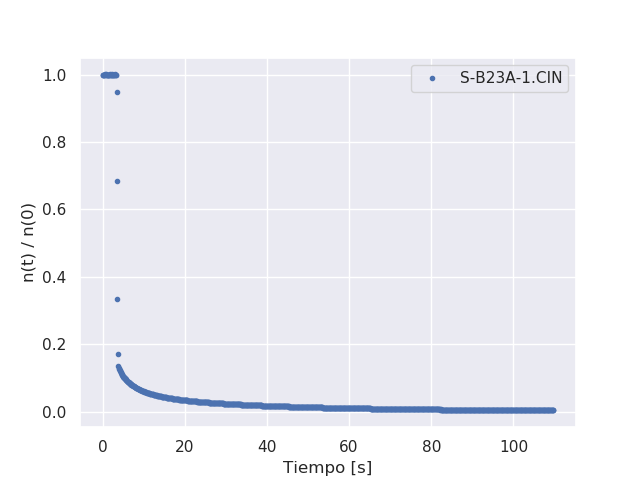


archivo       t_0        t_b             A3          $m       $i       $d        $p         EE

S-B23A-1     3.295    0.278(33)    -0.797(52)e-4    4.25(2)   5.63    5.94    5.524(6)    30.1
S-B23A-2     3.295    0.269(51)     0.1122(8)e-2    4.24(2)   4.46    4.50    4.445(4)     4.8
SCT-13-1     6.714    0.378(28)    -0.1264(2)e-2   10.5(1)   15.33   15.77    15.14(2)    45
SCT-13-2     6.714    0.375(42)    -0.974(3)e-3   10.99(15)  14.46   14.66    14.42(1)    32

Los cuatro archivos anteriores se ajustaron con constantes de Tuttle, RA1, entre 6 y 80 s (después del rod-drop!)


In [25]:
# Se lee el archivo .CIN
folder = "data"

archivo = "S-B23A-1.CIN"
#archivo = "S-B23A-2.CIN"
#archivo = "SCT-13-1.CIN"
#archivo = "SCT-13-2.CIN"

file_path = os.path.join(folder, archivo)

t_cin, n_cin = lee_archivo_CIN(file_path)

# Invervalo que se toma de referencia para normalizar y para obtener el t0
t_i_ref = 0.1
t_f_ref = 3.0
_intervalo_ref = (t_cin >= t_i_ref) & (t_cin <= t_f_ref)

n_cin_nor = n_cin / np.mean(n_cin[_intervalo_ref])

t_cero = deteccion_borde(t_cin, n_cin_nor, (t_i_ref, t_f_ref), n_sigmas=3.5)
print("t_cero = {} s".format(t_cero))

fig1, ax1 = plt.subplots(1)
ax1.plot(t_cin, n_cin_nor, '.', label=archivo)
ax1.set_xlabel(r'Tiempo [s]')
ax1.set_ylabel(r'n(t) / n(0)')
ax1.legend()
plt.show()

!cat data/resultados_fercin4.txt

### 2. Se selecciona el juego de constantes

In [14]:
# Se leen juego de cosntantes nucleares de neutrones retardados
b, lam , beta = lee_constantes_retardados('Tuttle')

if "B23A" in archivo:
    from constantes.constantes_reactores import RA1 as REACTOR
elif "SCT" in archivo:
    from constantes.constantes_reactores import RA3 as REACTOR
# Se leen constantes características de cada reactor

Lambda_red = REACTOR.LAMBDA_REDUCIDO

constantes_cineticas = b, lam, Lambda_red

### 3. Se ajusta $C_N(t)$ con $f(t)$ y se obtiene $A_3^{(1)}$

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 674
    # variables        = 4
    chi-square         = 8.3856e-07
    reduced chi-square = 1.2516e-09
    Akaike info crit   = -13812.2402
    Bayesian info crit = -13794.1872
[[Variables]]
    rho: -4.93079891 +/- 0.21231654 (4.31%) (init = -1)
    t1:   3.41737503 +/- 0.04149143 (1.21%) (init = 1)
    n0:   1 (fixed)
    A1:   0.88115609 +/- 0.03918037 (4.45%) (init = 1)
    A3:  -6.9684e-06 +/- 1.9600e-05 (281.27%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, A1) = -1.000
    C(t1, A1)  = -0.995
    C(rho, t1) =  0.994
    C(rho, A3) = -0.984
    C(A1, A3)  =  0.982
    C(t1, A3)  = -0.964


<IPython.core.display.Javascript object>


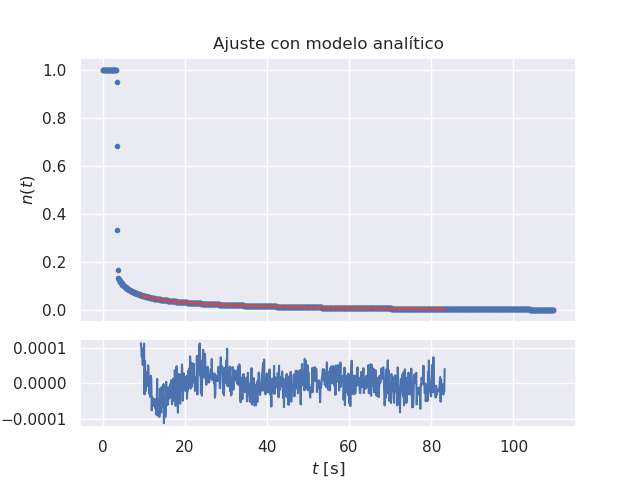

A3 = (-0.697+/-1.960)e-05


In [17]:
t_fit_i = t_cero + 6
t_fit_f = t_cero + 80

parametros = {
              't_ajuste': (t_fit_i, t_fit_f), 
              'constantes_cineticas': constantes_cineticas,
              't1_vary': True,
              'A1_vary': True,
              'A3_vary': True,
              }

result = ajuste_simulacion_espacial(t_cin, n_cin_nor, **parametros)

from lmfit import fit_report
print(fit_report(result))

# Gráficos
if True:
    
    ind_fit = (t_cin >= t_fit_i) & (t_cin <= t_fit_f)
    best_fit = n_cin_nor[ind_fit] + result.residual 
    
    fig3, (ax0, ax1) = plt.subplots(2, sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]},
                                   )
    # Grafico de ajuste
    ax0.errorbar(t_cin, n_cin_nor, fmt='.', elinewidth=2,
                 label='measurement', capsize=4)
    ax0.plot(t_cin[ind_fit], best_fit, 'r', zorder=3, label='fit', lw=2)
    ax0.set_ylabel(r'$n(t)$')
    ax0.set_title('Ajuste con modelo analítico')
    
    # Gráfico de residuos
    ax1.plot(t_cin[ind_fit], result.residual )
    ax1.set_xlabel(r'$t$ [s]')
    ax1.set_ylabel(r'Residuals')
    fig3.subplots_adjust(hspace=0.1)

A3 = ufloat(result.params['A3'].value, result.params['A3'].stderr)
print(f"A3 = {A3:.3e}")

### 4. A los $C_N(t)$ se le resta el valor obtenido $A_3^{(1)}$ y se aplica la cinética inversa para obtener $\$_p(t)$. Se promedian datos con algún criterio estadísticos en $t \gt t_0 + \Delta t_c$ y se obtiene el estimador $\$_{op}$

<IPython.core.display.Javascript object>


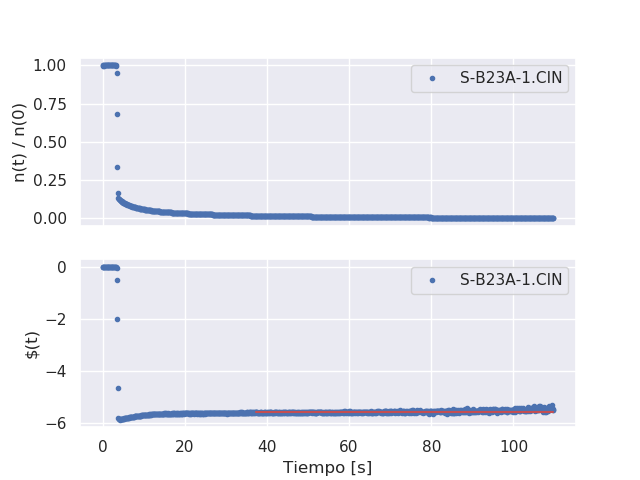

In [18]:
dt = t_cin[1]

####################
# A3 = ufloat(-1.2242e-03, 0)
# A3 = ufloat(-0.7972e-04, 0)
####################

rho_r, t_r, _ = reactimetro(n_cin_nor - A3.n, dt, lam, b, Lambda_red)

fig2, (ax21, ax22) = plt.subplots(2, 1, sharex=True)
ax21.plot(t_cin, n_cin_nor, '.', label=archivo)
ax21.set_ylabel(r"n(t) / n(0)")
ax21.legend()

ax22.plot(t_r, rho_r, '.', label=archivo)
ax22.set_ylabel(r"$(t)")
ax22.set_xlabel(r"Tiempo [s]")
ax22.legend()
#ax22.set_ylim(-6, -5.2)
plt.show()

In [19]:
# Se estima el tiempo de caída de la barra
t_caida, indx_t_caida = deteccion_tiempo_caida(t_r, rho_r, t_cero)
print("t_caida = {} s".format(t_caida))

# Estimar la reactividad promedio en una zona constante
rho_op, t_in_ajuste = estima_reactividad_reactimetro(t_r, rho_r, t_caida)
print(f"rho_op = {rho_op} obtenido a partir de t={t_in_ajuste:.2f} s")

_ind = t_r >= t_in_ajuste
_rho_cte = rho_op.n * np.ones(sum(_ind))
ax22.plot(t_r[_ind], _rho_cte, '-r', label=r"$\$_{op}$");

t_caida = 4.2840603 s
rho_op = -5.577+/-0.021 obtenido a partir de t=37.24 s


###  5. Se calcula $R(t) = \frac{$_p(t)} { $_p(t_0+\Delta t_c)}$  

In [20]:
rho_en_t_caida = rho_r[t_r==t_caida][-1]

# Se obtiene R(t)
R_t = rho_r / rho_en_t_caida

#TODO: comparar con la R_t obtenida con el fercin4

### 6. Se calcula $n(t)$ con la cinética directa utilizando $\$(t)=-\$_{op}R(t)$ 

<IPython.core.display.Javascript object>


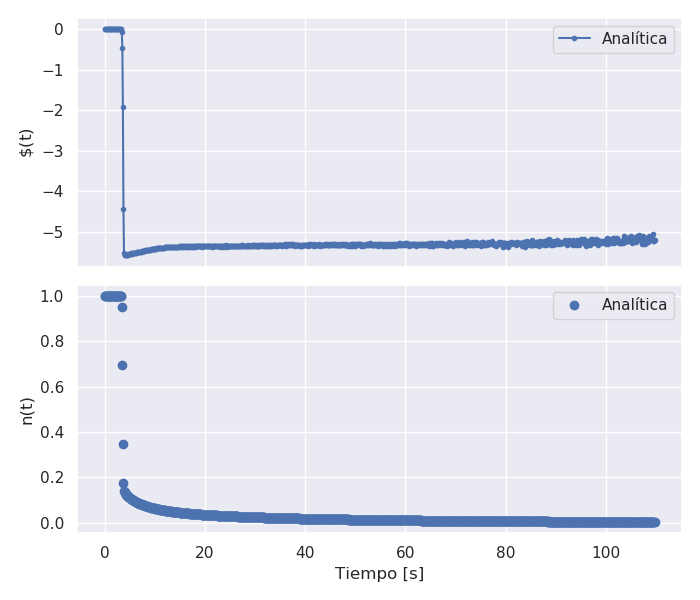

In [21]:
rho_pk = rho_op.n * R_t

n_sim, t_sim = cinetica_directa(rho_pk, 1, dt, lam, b, Lambda_red, 0)

# Graficación
fig, ax = plt.subplots(2, 1, figsize=(7,6), sharex=True)
ax[0].plot(t_r, rho_pk, '.-', label="Analítica")
ax[0].set_yscale('linear')
ax[0].set_ylabel(r'$\$$(t)')
ax[0].legend()

ax[1].plot(t_sim, n_sim, 'o', label='Analítica')
ax[1].set_ylabel('n(t)')
ax[1].set_xlabel('Tiempo [s]')
ax[1].legend()

fig.tight_layout()

plt.show()

### 7. Se ajusta $n(t)$ con $f(t)$ y se obtienen $t_b^{(i)}$ y $\$_{om}^{(0)}$

In [22]:
parametros = {
              't_ajuste': (t_fit_i, t_fit_f), 
              'constantes_cineticas': constantes_cineticas,
              't1_vary': True,
              'A3_vary': False,
              }

result = ajuste_simulacion_espacial(t_sim, n_sim, **parametros)

#rho_om = result.params['rho'].value, result.params['rho'].stderr
#t1 = result.params['t1'].value, result.params['t1'].stderr
t1 = ufloat(result.params['t1'].value, result.params['t1'].stderr)
tb = t1 - t_cero
rho_om = ufloat(result.params['rho'].value, result.params['rho'].stderr)
print(f"$_{{om}} = {rho_om:.3e}")
print(f"t_b = {tb:.3e} s")

# Debugg
print(f"t_1 = {t1:.3e} s")
print(f"t_0 = {t_cero:.3f} s")
print(archivo)

$_{om} = (-4.722+/-0.035)e+00
t_b = (1.239+/-0.110)e-01 s
t_1 = (3.419+/-0.011)e+00 s
t_0 = 3.295 s
S-B23A-1.CIN


### 8. Se ajustan a los datos $C_N(t)$ con la función $f(t)$ dejando $t_b = t_b^{(i)}$ como parámetro fijo. Se obtienen $\$_{om}^{(i)}$ y $A_3^{(i)}$

In [23]:
parametros = {
              't_ajuste': (t_fit_i, t_fit_f), 
              'constantes_cineticas': constantes_cineticas,
              't1_vary': False,
              't1_value': t1.n,
              #'t1_value': 3.551,
              'A3_vary': True,
              }

result = ajuste_simulacion_espacial(t_cin, n_cin_nor, **parametros)

rho_om = ufloat(result.params['rho'].value, result.params['rho'].stderr)
A3 = ufloat(result.params['A3'].value, result.params['A3'].stderr)

print(f"t_b = {tb:.3e} s")
print(f"A3 = {A3:.3e} s")
print(f"$_{{om}} = {rho_om:.3e}")
print(f"Archivo {archivo}")

t_b = (1.239+/-0.110)e-01 s
A3 = (-7.852+/-5.191)e-06 s
$_{om} = (-4.921+/-0.022)e+00
Archivo S-B23A-1.CIN


In [24]:
!cat data/resultados_fercin4.txt


archivo       t_0        t_b             A3          $m       $i       $d        $p         EE

S-B23A-1     3.295    0.278(33)    -0.797(52)e-4    4.25(2)   5.63    5.94    5.524(6)    30.1
S-B23A-2     3.295    0.269(51)     0.1122(8)e-2    4.24(2)   4.46    4.50    4.445(4)     4.8
SCT-13-1     6.714    0.378(28)    -0.1264(2)e-2   10.5(1)   15.33   15.77    15.14(2)    45
SCT-13-2     6.714    0.375(42)    -0.974(3)e-3   10.99(15)  14.46   14.66    14.42(1)    32

Los cuatro archivos anteriores se ajustaron con constantes de Tuttle, RA1, entre 6 y 80 s (después del rod-drop!)
